# Burst Analysis Workflow - IOT
- Input:
    * sci2-iot-nsf-output.csv
    * sci2-iot-wos-output.csv

In [1]:
%matplotlib inline
import sys
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import pylab as plt
import math
from os import listdir
import random
import time
import matplotlib.cm as cm
from numpy.random import choice
import itertools
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
import re
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from matplotlib.ticker import MaxNLocator

In [2]:
area='iot'

## Step 1 Normalize keywords in OpenRefine (see documentation)
## Step 2 Run Burst Analysis in Sci2
- input: 
    * [area]\_wos_keywords.csv
    * [area]\_nsf_keywords.csv
- get output:
    * [area]\_wos_input.csv
    * [area]\_nsf_input.csv

## Step 3 Get Burst Graph

### 1) Load data generated from Sci2

In [14]:
wos_burst_path='sci2-iot-wos-output.csv'
nsf_burst_path='sci2-iot-nsf-output.csv'
WOSkw = pd.read_csv(wos_burst_path)
NSFkw = pd.read_csv(nsf_burst_path)
NSFkw['Word'] = NSFkw['Word'].str.replace('-',' ')  # remove underscores
WOSkw['Word'] = WOSkw['Word'].str.replace('-',' ')  # remove underscores
WOSkw['Word'] = WOSkw['Word'].str.lower() 

In [15]:
### Merge two sets
WOSkw['Word'] = WOSkw['Word'].str.title() 
WOSkw['cat'] = 'wos'
NSFkw['Word'] = NSFkw['Word'].str.title() 
NSFkw['cat'] = 'nsf'
#nsfwosai15 = pd.concat([wosai15, nsfai15], ignore_index=True)
nsfwosai = pd.concat([WOSkw, NSFkw], ignore_index=True)

In [16]:
print('Total WOS IOT bursts:', len(WOSkw))
print('Total NSF IOT bursts:', len(NSFkw))

Total WOS IOT bursts: 77
Total NSF IOT bursts: 77


### Sort

In [17]:
#Top Bursts
print('nsf-max',max(NSFkw.Weight),NSFkw.loc[NSFkw.Weight==max(NSFkw.Weight),'Word'].values[0])
print('wos-max',max(WOSkw.Weight),WOSkw.loc[WOSkw.Weight==max(WOSkw.Weight),'Word'].values[0])
print('nsf-min',min(NSFkw.Weight),NSFkw.loc[NSFkw.Weight==min(NSFkw.Weight),'Word'].values[0])
print('wos-min',min(WOSkw.Weight),WOSkw.loc[WOSkw.Weight==min(WOSkw.Weight),'Word'].values[0])

nsf-max 4.2555282960000005 Vehicles
wos-max 62.154923600000004 Rfid
nsf-min 1.796352126 Tiny
wos-min 2.7137217760000003 Service


### Double Bursts 

In [18]:
# WOS Double Burst
# Select all duplicate terms based on Word column
dub = WOSkw[WOSkw.duplicated(['Word'], keep=False)].sort_values('Word',ascending=False)
dub.groupby('Word')['cat'].count()

Series([], Name: cat, dtype: int64)

In [19]:
#NSF Double Burst
dub = NSFkw[NSFkw.duplicated(['Word'], keep=False)].sort_values('Word',ascending=False)
dub.groupby('Word')['cat'].count()
print(len(dub.groupby('Word')['cat'].count()))
dub.groupby('Word')['cat'].count()

0


Series([], Name: cat, dtype: int64)

In [20]:
# Select all duplicate terms based on Word column
#duplicates = nsfwosai[nsfwosai.duplicated(['Word'], keep=False)]
#duplicates.sort_values(['Word'])
#WOSkw.head()
set1 = set(NSFkw.Word)
set2 =  set(WOSkw.Word)
print('Overlapped keywords between NSF/WOS - ',len(set1.intersection(set2)))

Overlapped keywords between NSF/WOS -  0


### Top 10

In [21]:
wos_top={}

# sum weight and pick top15
for i in WOSkw.index:
    word=WOSkw['Word'][i].lower()
    weight=WOSkw['Weight'][i]
    start=WOSkw['Start'][i]
    end=WOSkw['End'][i]
    if word in wos_top:
        wos_top[word][0]+=weight
        if start<wos_top[word][1]:
            wos_top[word][1]=start
            wos_top[word][2]=end 
    else:
        wos_top[word]=[weight,start,end]

wos_df=pd.DataFrame.from_dict(wos_top,
                       orient='index', columns=['sum_weight', 'first_start','end'])

wos_topdf=wos_df.sort_values(ascending=[False],by=['sum_weight'])[0:10]  

for i in WOSkw.index:
    if WOSkw['Word'][i].lower() not in wos_topdf.index:
        WOSkw=WOSkw.drop([i])
WOSkw=WOSkw.reset_index(drop=True)        
WOSkw['Word']=[i.lower() for i in list(WOSkw['Word'])]

In [22]:
nsf_top={}

# sum weight and pick top15
for i in NSFkw.index:
    word=NSFkw['Word'][i].lower()
    weight=NSFkw['Weight'][i]
    start=NSFkw['Start'][i]
    end=NSFkw['End'][i]
    if word in nsf_top:
        nsf_top[word][0]+=weight
        if start<nsf_top[word][1]:
            nsf_top[word][1]=start
            nsf_top[word][2]=end        
    else:
        nsf_top[word]=[weight,start,end]

nsf_df=pd.DataFrame.from_dict(nsf_top,
                       orient='index', columns=['sum_weight', 'first_start','end'])

nsf_topdf=nsf_df.sort_values(ascending=[False],by=['sum_weight'])[0:10]  

#nsf_topdf=nsf_topdf.sort_values(ascending=[True,False],by=['first_start','sum_weight']) 

#NSFkw.loc[]

for i in NSFkw.index:
    if NSFkw['Word'][i].lower() not in nsf_topdf.index:
        NSFkw=NSFkw.drop([i])
NSFkw=NSFkw.reset_index(drop=True)     
NSFkw['Word']=[i.lower() for i in list(NSFkw['Word'])]

In [23]:
allkw_list=pd.concat([nsf_topdf,wos_topdf])
allkw_list=allkw_list.sort_values(ascending=[True,True,False],by=['first_start','end','sum_weight'])
allkw_list=allkw_list.reset_index()

#### Overlap between NSf and WOS

In [24]:
overlap=allkw_list[list(allkw_list['index'].duplicated()==True)]
allkw_list=allkw_list[list(allkw_list['index'].duplicated()!=True)] #remove duplicated
allkw_list=allkw_list.reset_index()

In [25]:
overlap_list=pd.DataFrame(columns=['Word','Length','Weight','Start','End'])
for i in range(len(overlap)):
    print(overlap['index'].values[i]+'-NSF: ')
    print(len(NSFkw.loc[NSFkw.Word==overlap['index'].values[i],]))
    print(overlap['index'].values[i]+'-WOS: ')
    print(len(WOSkw.loc[WOSkw.Word==overlap['index'].values[i],]))
    nsf_ol=NSFkw.loc[NSFkw.Word==overlap['index'].values[i],]
    wos_ol=WOSkw.loc[WOSkw.Word==overlap['index'].values[i],]
    nsf_ol=nsf_ol.reset_index()
    wos_ol=wos_ol.reset_index()
    for k in range(len(nsf_ol)):
        for j in range(len(wos_ol)):
            Word=nsf_ol.loc[k,'Word']
            Level=1
            Weight=max(nsf_ol.loc[k,'Weight'],wos_ol.loc[j,'Weight'])
            max_Start=max(nsf_ol.loc[k,'Start'],wos_ol.loc[j,'Start'])
            min_End=min(nsf_ol.loc[k,'End'],wos_ol.loc[j,'End'])
            if max_Start<=min_End: ##has overlapped year 
                overlap_list.loc[len(overlap_list),['Word','Weight','Start','End']]=[Word,Weight,max_Start,min_End]
                overlap_list.loc[len(overlap_list)-1,['Length']]=[min_End-max_Start+1]
        


In [26]:
overlap_list

,Word,Length,Weight,Start,End


In [27]:
WOSkw['Word'] = WOSkw['Word'].str.title() 
NSFkw['Word'] = NSFkw['Word'].str.title() 
overlap_list['Word'] = overlap_list['Word'].str.title()
allkw_list['index'] = allkw_list['index'].str.title()

### 2) Graph

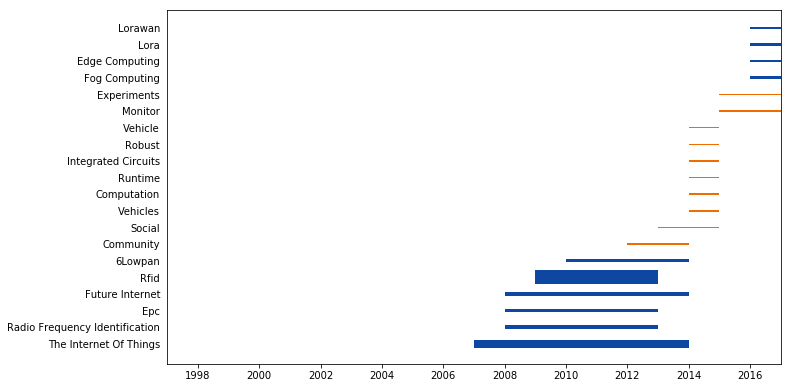

In [28]:
plt.rcParams['svg.fonttype'] = 'none'
fig = plt.figure(figsize=(11, 6.5),facecolor='white')
#end = np.array(df[['stop']])
ax1 = fig.add_subplot(111)
ax1.set_xlim((1997, 2017))

my_yticks=allkw_list['index']
y = list(range(0, len(allkw_list)))
plt.yticks(y, my_yticks)
ax1.yaxis.set_ticks_position('none')   

for x in range(0,len(WOSkw)):
    color="#0d47a1" #blue -- wos
    i=allkw_list.index[allkw_list['index']==WOSkw['Word'][x]].values[0]
    
    ax1.barh([i], width=WOSkw[x:(x+1)].Length, left=WOSkw[x:(x+1)].Start-1, color=color,height=WOSkw[x:(x+1)].Weight/max(max(WOSkw.Weight),max(NSFkw.Weight))*0.8+0.03,alpha=1)
#     ax1.barh([8], width=9, left=1997, color=color,height=0.05+0.03,alpha=1)
#     ax1.barh([8], width=9, left=1997, color=color,height=0.05+0.03,alpha=1)
  
for x in range(0,len(NSFkw)):
    color="#ef6c00" #orange -- nsf
    i=allkw_list.index[allkw_list['index']==NSFkw['Word'][x]].values[0]
    
    ax1.barh([i], width=NSFkw[x:(x+1)].Length, left=NSFkw[x:(x+1)].Start-1, color=color,height=NSFkw[x:(x+1)].Weight/max(max(WOSkw.Weight),max(NSFkw.Weight))*0.8+0.03,alpha=1)

    
for x in range(0,len(overlap_list)):
    color="grey" #grey -- nsf
    i=allkw_list.index[allkw_list['index']==overlap_list['Word'][x]].values[0]
    
    ax1.barh([i], width=overlap_list[x:(x+1)].Length, left=overlap_list[x:(x+1)].Start-1, color=color,height=overlap_list[x:(x+1)].Weight/max(max(WOSkw.Weight),max(NSFkw.Weight))*0.8+0.03,alpha=1)


    
ax1 = plt.gca()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(area+'-burst.svg')
plt.savefig(area+'-burst.png')